In [1163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, roc_curve

In [1164]:
class LogisticRegression(object):
    def __init__(self, X_train, y_train, X_test, y_test, learn_rate=0.001, n_iters=500, reg_param=0.1):
        if len(X_train.shape) == 1:
            self.X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train.reshape(-1, 1)))
        else:
            self.X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
        self.y_train = y_train

        if len(X_test.shape) == 1:
            self.X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test.reshape(-1, 1)))
        else:
            self.X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
        self.y_test = y_test

        self.learn_rate = learn_rate
        self.n_iters = n_iters 
        self.reg_param = reg_param

        # Initialize model weights with small random values
        self.weight = np.random.randn(self.X_train.shape[1])

        self.accuracy_train = []  # To keep track of accuracy on the training data during gradient ascent process
        self.accuracy_test = []  # To keep track of accuracy on the test data during gradient ascent process

        self.log_likelihood_train = []  # To keep track of average log likelihood on the training data during gradient ascent process
        self.log_likelihood_test = []  # To keep track of average log likelihood on the test data during gradient ascent process

    def predict(self, samples, threshold=0.5):
        return self.predict_prob(samples) >= threshold

    def predict_prob(self, samples):
        if samples.shape[1] != self.X_train.shape[1]:
            samples = np.hstack((np.ones((samples.shape[0], 1)), samples))
        probs = 1 / (1 + np.exp(-np.dot(samples, self.weight)))
        return probs

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def compute_gradient(self):
        predict = self.predict_prob(self.X_train)
        error = self.y_train - predict

        # Add L2 regularization term to the gradient
        reg_term = self.reg_param * self.weight
        reg_term[0] = 0  # Exclude bias term from regularization
        return -np.dot(self.X_train.T, error) + reg_term / len(self.y_train)


    def gradient_ascent(self):
        for _ in range(self.n_iters):
            gradient = self.compute_gradient()
            self.weight += self.learn_rate * gradient / len(self.y_train)

            # log-likelihood for train and test data:
            pred_train = self.predict_prob(self.X_train)
            log_like_train = -np.mean(self.y_train * np.log(pred_train + 1e-10) + (1 - self.y_train) * np.log(1 - pred_train + 1e-10))

            pred_test = self.predict_prob(self.X_test)
            log_like_test = -np.mean(self.y_test * np.log(pred_test + 1e-10) + (1 - self.y_test) * np.log(1 - pred_test + 1e-10))

            # accuracy for train and test data:
            accuracy_train = np.mean(self.predict(self.X_train) == self.y_train)
            self.accuracy_train.append(accuracy_train)

            accuracy_test = np.mean(self.predict(self.X_test) == self.y_test)
            self.accuracy_test.append(accuracy_test)

            # Store log likelihood values
            self.log_likelihood_train.append(log_like_train)
            self.log_likelihood_test.append(log_like_test)


In [1165]:
def preprocess_data(X_train, X_test):
    cat_cols = X_train.select_dtypes(include=['object']).columns
    num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

    # Initialize OneHotEncoder
    cat_encoder = OneHotEncoder(sparse_output=False, drop='first')

    # Combine training and test data for consistent encoding
    combined_data = pd.concat([X_train, X_test], axis=0)

    # Fit OneHotEncoder on combined categorical data
    cat_encoder.fit(combined_data[cat_cols])

    # Initialize StandardScaler
    scaler = StandardScaler()

    # Transform categorical and numerical features for training data
    processed_X_train = pd.DataFrame(np.hstack([cat_encoder.transform(X_train[cat_cols]), 
                                                scaler.fit_transform(X_train[num_cols])]),
                                      columns=np.concatenate([cat_encoder.get_feature_names_out(cat_cols),
                                                             num_cols]))

    # Transform categorical and numerical features for test data
    processed_X_test = pd.DataFrame(np.hstack([cat_encoder.transform(X_test[cat_cols]), 
                                               scaler.transform(X_test[num_cols])]),
                                     columns=np.concatenate([cat_encoder.get_feature_names_out(cat_cols),
                                                            num_cols]))

    return processed_X_train, processed_X_test


In [1166]:
def plot_log_likelihood_performance(log_likelihood_train, log_likelihood_test):
    # Todo: plot the average log likelihood curves of the training and test sets
    #      during training process
    plt.plot(log_likelihood_train, label='Training Set')
    plt.plot(log_likelihood_test, label='Testing Set')
    plt.xlabel('Iterations')
    plt.ylabel('Average log-likelihood')
    
    plt.legend()
    plt.show()

In [1167]:
def plot_accuracy_performance(accuracy_train, accuracy_test):
    # Todo: plot the prediction accuracy curves of the training and test sets
    #      during the training process
    plt.plot(accuracy_train, label='Train Accuracy')
    plt.plot(accuracy_test, label='Test Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Performance During Training')
    
    plt.legend()
    plt.show()

In [1168]:
# def plot_roc(X_train, y_train, X_test, y_test, learner):
#     # Get predicted probabilities for the positive class
#     y_train_prob = learner.predict_prob(X_train)
#     y_test_prob = learner.predict_prob(X_test)

#     # Calculate ROC curve and AUC for training set
#     fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
#     auc_train = auc(fpr_train, tpr_train)

#     # Calculate ROC curve and AUC for testing set
#     fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
#     auc_test = auc(fpr_test, tpr_test)

#     # Plot ROC curves
#     plt.plot(fpr_train, tpr_train, label=f'Training Set (AUC = {auc_train:.2f})')
#     plt.plot(fpr_test, tpr_test, label=f'Testing Set (AUC = {auc_test:.2f})')
#     plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic (ROC) - ROC Curves')
#     plt.legend()

#     plt.show()

def plot_roc(X_train, y_train, X_test, y_test, learner):
    # Get predicted probabilities for the positive class
    y_train_prob = learner.predict_prob(X_train)
    y_test_prob = learner.predict_prob(X_test)

    # Calculate ROC curve and AUC for training set
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
    auc_train = auc(fpr_train, tpr_train)

    # Calculate ROC curve and AUC for testing set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
    auc_test = auc(fpr_test, tpr_test)

    # Plot ROC curves
    plt.figure(figsize=(8, 8))
    plt.plot(fpr_train, tpr_train, label=f'Training Set (AUC = {auc_train:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Testing Set (AUC = {auc_test:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - ROC Curves')
    plt.legend()

    plt.show()

In [1169]:
# Load data
train_data = pd.read_csv('cleaned_train_data.csv')
test_data = pd.read_csv('cleaned_test_data.csv')
X_train = train_data.drop(['income'], axis=1, inplace=False)
y_train = train_data['income']
X_test = test_data.drop(['income'], axis=1, inplace=False)
y_test = test_data['income']

In [1170]:
# Preprocessing data
processed_X_train, processed_X_test = preprocess_data(X_train, X_test)

In [1171]:
# Run gradient ascent with Logistic Regression for learn_rate=0.75
learner = LogisticRegression(processed_X_train, y_train.values, processed_X_test, y_test.values,
                              n_iters=250, learn_rate=0.75)
learner.gradient_ascent()

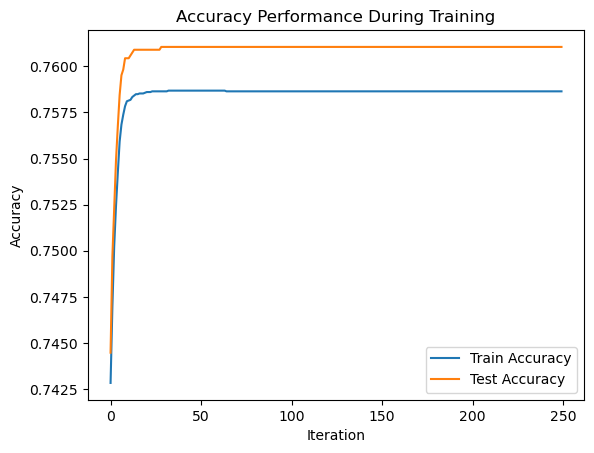

In [1172]:
# Plot prediction accuracy during training process
plot_accuracy_performance(learner.accuracy_train, learner.accuracy_test)

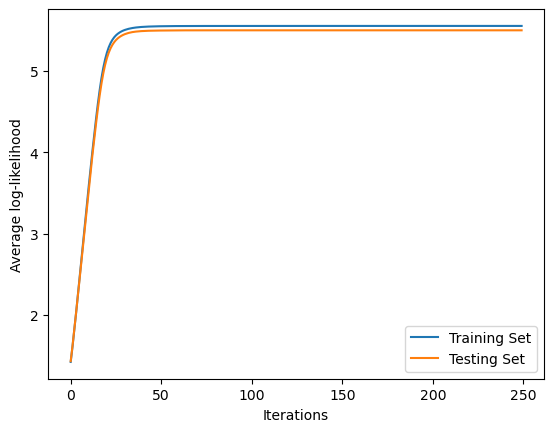

In [1173]:
# Plot Log Likelihood values during training process
plot_log_likelihood_performance(learner.log_likelihood_train, learner.log_likelihood_test)

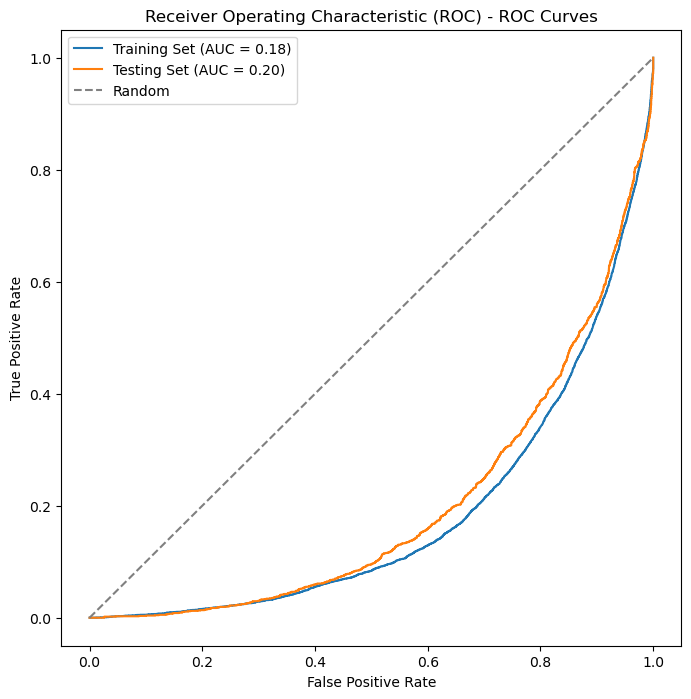

In [1174]:
# Plot ROC curves
plot_roc(processed_X_train, y_train, processed_X_test, y_test, learner)